# Импорт библиотек

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Union, List
from tqdm import tqdm

IN_COLAB = False

# Настройка окружения

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

if IN_COLAB:
    figures_dir = './'
else:
    figures_dir = '../figures/'

# Работа с данными

In [21]:
# rootpath = '/home/eduard/git/HTNet/' # pulling results from rootpath+dataset directory
# dataset = 'move_rest_ecog/combined_sbjs_power/'
# full_path = rootpath + dataset
#
# rnn_acc = np.load(full_path + 'acc_gen_rnn_36.npy')
# s4_acc = np.load(full_path + 'acc_gen_s4_36.npy')
# ncde_acc = np.load(full_path + 'acc_gen_ncde_36.npy')
rnn_acc = np.load('rnn_acc.npy')
s4_acc = np.load('s4_acc.npy')
ncde_acc = np.load('ncde_acc.npy')

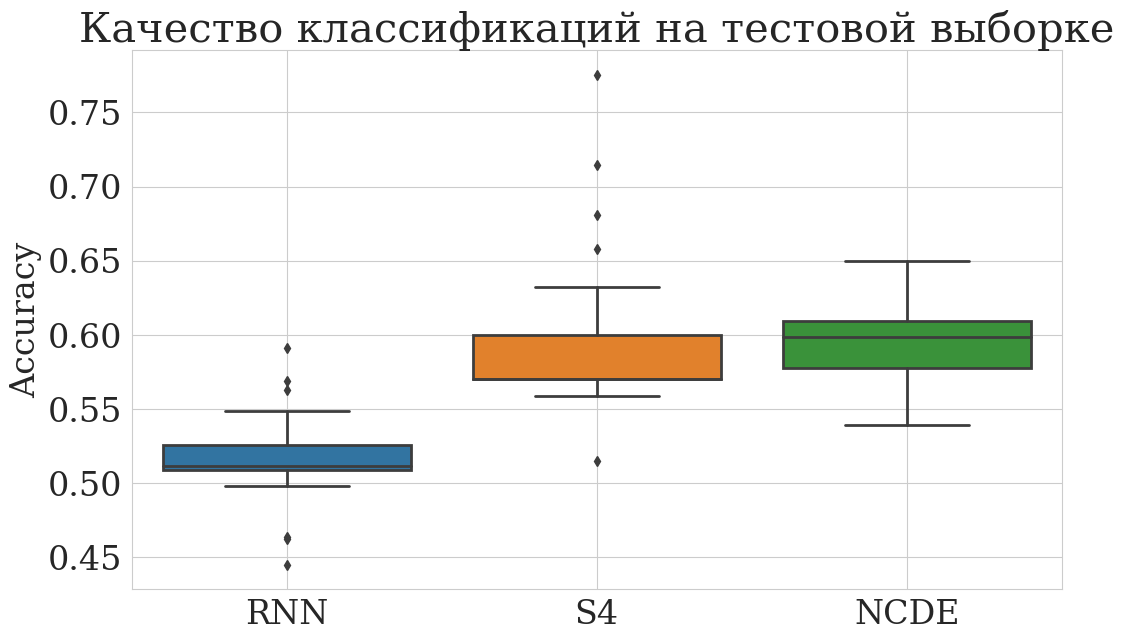

In [24]:
ax = plt.gca()
sns.boxplot([rnn_acc[:, -1], s4_acc[:, -1], ncde_acc[:, -1]], ax=ax)
plt.xticks(range(3), ['RNN', 'S4', 'NCDE'])
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Качество классификаций на тестовой выборке')
plt.savefig('rnn-s4-ncde.png')
plt.show()

In [26]:
rnn_acc[:, -1].mean(), rnn_acc[:, -1].std()

(0.5161688526846108, 0.027222627568199754)

In [27]:
s4_acc[:, -1].mean(), s4_acc[:, -1].std()

(0.5910854088633704, 0.048762742434324505)

In [28]:
ncde_acc[:, -1].mean(), ncde_acc[:, -1].std()

(0.5955534400103386, 0.026470510400540662)

## Визуализация данных

In [3]:
from utils import load_data


pats_ids_in = ['EC01', 'EC02', 'EC03', 'EC04', 'EC05', 'EC06', 'EC07', 'EC08', 'EC09', 'EC10', 'EC11', 'EC12']
lp = '/home/eduard/git/HTNet/ecog_data/'
sp = '/home/eduard/git/HTNet/move_rest_ecog/combined_sbjs_power/'
half_n_evs_test = 'nopad'
half_n_evs = 500 // 2
overwrite = True
n_chans_all = 126
test_day = 'last'
tlim = [-1, 1]

X, y, X_test_orig, y_test_orig, sbj_order, sbj_order_test_load = load_data(
    pats_ids_in, lp, n_chans_all=n_chans_all, test_day=test_day, tlim=tlim
)

X[np.isnan(X)] = 0  # set all NaN's to 0
y = y.astype(int)
y_test_orig = y_test_orig.astype(int)

labels_unique = np.unique(y)
nb_classes = len(np.unique(y))

100%|██████████| 12/12 [01:03<00:00,  5.32s/it]


Data loaded!


In [25]:
from utils import folds_choose_subjects, subject_data_inds


n_folds = 1
sbj_inds_all_train, sbj_inds_all_val, sbj_inds_all_test = folds_choose_subjects(n_folds, pats_ids_in,
                                                                                    n_test=1, n_val=4,
                                                                                    n_train=7)
test_sbj = sbj_inds_all_test[0]
val_sbj = sbj_inds_all_val[0]
train_sbj = sbj_inds_all_train[0]

train_inds, val_inds, test_inds = [], [], []
if test_day is None:
    test_inds = subject_data_inds(np.full(1, test_sbj), sbj_order, labels_unique, 0,
                                  'test_inds', half_n_evs_test, y, sp, n_folds, test_inds,
                                  overwrite)
else:
    test_inds = subject_data_inds(np.full(1, test_sbj), sbj_order_test_load, labels_unique, 0,
                                  'test_inds', half_n_evs_test, y_test_orig, sp, n_folds, test_inds,
                                  overwrite)
val_inds = subject_data_inds(val_sbj, sbj_order, labels_unique, 0,
                             'val_inds', half_n_evs, y, sp, n_folds, val_inds, overwrite)
train_inds = subject_data_inds(train_sbj, sbj_order, labels_unique, 0,
                               'train_inds', half_n_evs, y, sp, n_folds, train_inds, overwrite)

In [30]:
X_train = X[train_inds, ...]
Y_train = y[train_inds]
sbj_order_train = sbj_order[train_inds]
X_validate = X[val_inds, ...]
Y_validate = y[val_inds]
sbj_order_validate = sbj_order[val_inds]
if test_day is None:
    X_test = X[test_inds, ...]
    Y_test = y[test_inds]
    sbj_order_test = sbj_order[test_inds]
else:
    X_test = X_test_orig[test_inds, ...]
    Y_test = y_test_orig[test_inds]
    sbj_order_test = sbj_order_test_load[test_inds]

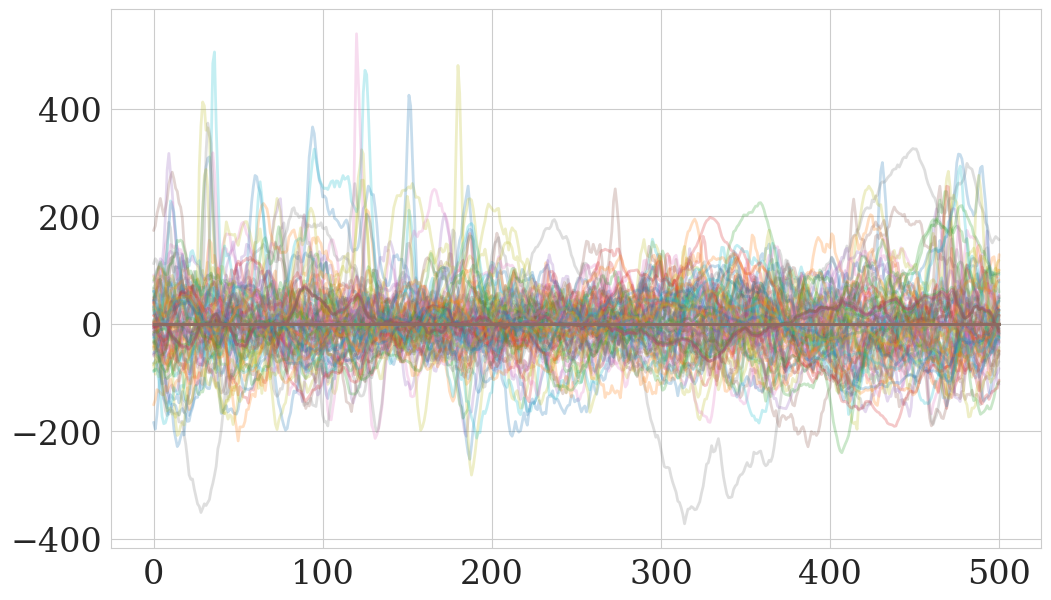

In [69]:
plt.plot(X_train[0].T, alpha=0.25);

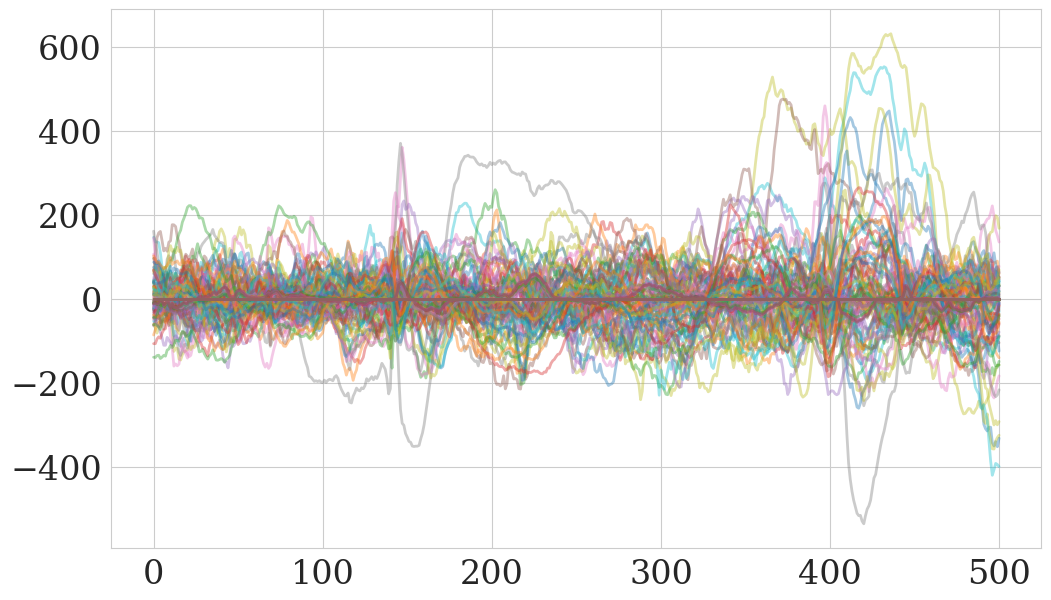

In [70]:
plt.plot(X_train[400].T, alpha=0.4);